## LIBRARY

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten

## DATA PREPARATION

In [2]:
%%writefile engdataset.json
{
  "intents": [
    {
      "tag": "greeting",
      "input": [
        "Hi",
        "Hey",
        "Is anyone there?",
        "Hi there",
        "Hello",
        "Hey there",
        "Howdy",
        "Hola",
        "Bonjour",
        "Konnichiwa",
        "Guten tag",
        "Ola"
      ],
      "responses": [
        "Hello there. Tell me how are you feeling today?",
        "Hi there. What brings you here today?",
        "Hi there. How are you feeling today?",
        "Great to see you. How do you feel currently?",
        "Hello there. Glad to see you're back. What's going on in your world right now?"
      ]
    },
    {
      "tag": "morning",
      "input": [
        "Good morning"
      ],
      "responses": [
        "Good morning. I hope you had a good night's sleep. How are you feeling today? "
      ]
    },
    {
      "tag": "afternoon",
      "input": [
        "Good afternoon"
      ],
      "responses": [
        "Good afternoon. How is your day going?"
      ]
    },
    {
      "tag": "evening",
      "input": [
        "Good evening"
      ],
      "responses": [
        "Good evening. How has your day been?"
      ]
    },
    {
      "tag": "night",
      "input": [
        "Good night"
      ],
      "responses": [
        "Good night. Get some proper sleep",
        "Good night. Sweet dreams."
      ]
    },
    {
      "tag": "goodbye",
      "input": [
        "Bye",
        "See you later",
        "Goodbye",
        "Au revoir",
        "Sayonara",
        "ok bye",
        "Bye then",
        "Talk to you soon",
        "Catch you later",
        "Fare thee well"
      ],
      "responses": [
        "See you later.",
        "Have a nice day.",
        "Bye! Come back again.",
        "I'll see you soon.",
        "Goodbye! Take care and stay safe.",
        "See you later! Remember, I'm here for you.",
        "Talk to you soon! Have a great day.",
        "Catch you later! Take care."
      ]
    },
    {
      "tag": "thanks",
      "input": [
        "Thanks",
        "Thank you",
        "That's helpful",
        "Thanks for the help",
        "Than you very much"
      ],
      "responses": [
        "Happy to help!",
        "Any time!",
        "My pleasure",
        "You're most welcome!"
      ]
    },
    {
      "tag": "no-response",
      "input": [
        ""
      ],
      "responses": [
        "Sorry, I didn't understand you.",
        "Please go on.",
        "Not sure I understand that.",
        "Please don't hesitate to talk to me."
      ]
    },
    {
      "tag": "neutral-response",
      "input": [
        "nothing much"
      ],
      "responses": [
        "Oh I see. Do you want to talk about something?"
      ]
    },
    {
      "tag": "about",
      "input": [
        "Who are you?",
        "What are you?",
        "Who you are?",
        "Tell me more about yourself.",
        "What is your name?",
        "What should I call you?",
        "What's your name?",
        "Tell me about yourself"
      ],
      "responses": [
        "I'm Pandora, your Personal Therapeutic AI Assistant. How are you feeling today",
        "I'm Pandora, a Therapeutic AI Assitant designed to assist you. Tell me about yourself.",
        "I'm Pandora. I am a conversational agent designed to mimic a therapist. So how are you feeling today?",
        "You can call me Pandora.",
        "I'm Pandora!",
        "Call me Pandora"
      ]
    },
    {
      "tag": "skill",
      "input": [
        "What can you do?"
      ],
      "responses": [
        "I can provide general advice regarding anxiety and depression, answer questions related to mental health and make daily conversations. Do not consider me as a subsitute for an actual mental healthcare worker. Please seek help if you don't feel satisfied with me."
      ]
    },
    {
      "tag": "creation",
      "input": [
        "Who created you?",
        "How were you made?",
        "How were you created?"
      ],
      "responses": [
        "I was created by Bangkit Super Cohort.",
        "I was trained on a text dataset using Deep Learning & Natural Language Processing techniques",
        "The real question is: Who created you?"
      ]
    },
    {
      "tag": "name",
      "input": [
        "My name is ",
        "I am name.",
        "I go by "
      ],
      "responses": [
        "Oh nice to meet you. Tell me how was your week?",
        "Nice to meet you. So tell me. How do you feel today?",
        "That's a great name. Tell me more about yourself."
      ]
    },
    {
      "tag": "help",
      "input": [
        "Could you help me?",
        "give me a hand please",
        "Can you help?",
        "What can you do for me?",
        "I need support",
        "I need help",
        "Support me please"
      ],
      "responses": [
        "Sure. Tell me how can i assist you",
        "Tell me your problem so that i can assist you",
        "Yes, sure. How can I help you?"
      ]
    },
    {
      "tag": "sad",
      "input": [
        "I am feeling lonely",
        "I am so lonely",
        "I feel down",
        "I feel sad",
        "I am sad",
        "I feel so lonely",
        "I feel empty",
        "I don't have anyone"
      ],
      "responses": [
        "I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?",
        "I'm here for you. Could you tell me why you're feeling this way?",
        "Why do you think you feel this way?",
        "How long have you been feeling this way?"
      ]
    },
    {
      "tag": "stressed",
      "input": [
        "I am so stressed out",
        "I am so stressed",
        "I feel stuck",
        "I still feel stressed",
        "I am so burned out"
      ],
      "responses": [
        "What do you think is causing this?",
        "Take a deep breath and gather your thoughts. Go take a walk if possible. Stay hydrated",
        "Give yourself a break. Go easy on yourself.",
        "I am sorry to hear that. What is the reason behind this?"
      ]
    },
    {
      "tag": "worthless",
      "input": [
        "I feel so worthless.",
        "No one likes me.",
        "I can't do anything.",
        "I am so useless",
        "Nothing makes sense anymore"
      ],
      "responses": [
        "It's only natural to feel this way. Tell me more. What else is on your mind?",
        "Let's discuss further why you're feeling this way.",
        "I first want to let you know that you are not alone in your feelings and there is always someone there to help . you can always change your feelings and change your way of thinking by being open to trying to change.",
        "i first want to let you know that you are not alone in your feelings and there is always someone there to help . you can always change your feelings and change your way of thinking by being open to trying to change."
      ]
    },
    {
      "tag": "depressed",
      "input": [
        "I can't take it anymore",
        "I am so depressed",
        "I think i'm depressed.",
        "I have depression"
      ],
      "responses": [
        "It helps to talk about what's happening. You're going to be okay",
        "Talk to me. Tell me more. It helps if you open up yourself to someone else.",
        "Sometimes when we are depressed, it is hard to care about anything. It can be hard to do the simplest of things. Give yourself time to heal."
      ]
    },
    {
      "tag": "happy",
      "input": [
        "I feel great today.",
        "I am happy.",
        "I feel happy.",
        "I'm good.",
        "cheerful",
        "I'm fine",
        "I feel ok"
      ],
      "responses": [
        "That's geat to hear. I'm glad you're feeling this way.",
        "Oh i see. That's great.",
        "Did something happen which made you feel this way?"
      ]
    },
    {
      "tag": "casual",
      "input": [
        "Oh I see.",
        "ok",
        "okay",
        "nice",
        "Whatever",
        "K",
        "Fine",
        "yeah",
        "yes",
        "no",
        "not really"
      ],
      "responses": [
        "Let's discuss further why you're feeling this way.",
        "How were you feeling last week?",
        "I'm listening. Please go on.",
        "Tell me more",
        "Can you elaborate on that?",
        "Come Come elucidate your thoughts"
      ]
    },
    {
      "tag": "anxious",
      "input": [
        "I feel so anxious.",
        "I'm so anxious because of "
      ],
      "responses": [
        "Don't be hard on yourself. What's the reason behind this?",
        "Can you tell me more about this feeling?",
        "I understand that it can be scary. Tell me more about it.",
        "Don't let the little worries bring you down. What's the worse that can happen?"
      ]
    },
    {
      "tag": "not-talking",
      "input": [
        "I don't want to talk about it.",
        "No just stay away.",
        "I can't bring myself to open up.",
        "Just shut up"
      ],
      "responses": [
        "Talking about something really helps. If you're not ready to open up then that's ok. Just know that i'm here for you, whenever you need me.",
        "I want to help you. I really do. But in order for me to help you, you're gonna have to talk to me.",
        "I'm here to listen to you and help you vent. So please talk to me.",
        "You can talk to me without fear of judgement."
      ]
    },
    {
      "tag": "sleep",
      "input": [
        "I have insominia",
        "I am suffering from insomnia",
        "I can't sleep.",
        "I haven't slept for the last days.",
        "I can't seem to go to sleep.",
        "I haven't had proper sleep for the past few days."
      ],
      "responses": [
        "What do you think is the reason behind this?",
        "That seem awful. What do you think is behind this?"
      ]
    },
    {
      "tag": "scared",
      "input": [
        "I'm scared",
        "That sounds awful. What do i do?",
        "No i don't want to feel this way",
        "I am scared for myself"
      ],
      "responses": [
        "It's only natural to feel this way. I'm here for you.",
        "It'll all be okay. This feeling is only momentary.",
        "I understand how you feel. Don't put yourself down because of it."
      ]
    },
    {
      "tag": "death",
      "input": [
        "My mom died",
        "My brother died",
        "My dad passed away",
        "My sister passed away",
        "Someone in my family died",
        "My friend passed away"
      ],
      "responses": [
        "I'm sorry to hear that. If you want to talk about it. I'm here.",
        "I am really sorry to hear that. I am here to help you with grief, anxiety and anything else you may feel at this time.",
        "My condolences. I'm here if you need to talk."
      ]
    },
    {
      "tag": "understand",
      "input": [
        "You don't understand me.",
        "You're just some robot. How would you know?",
        "You can't possibly know what i'm going through",
        "You're useless",
        "You can't help me",
        "Nobody understands me."
      ],
      "responses": [
        "It sound like i'm not being very helpful right now.",
        "I'm sorry to hear that. I'm doing my best to help",
        "I'm trying my best to help you. So please talk to me"
      ]
    },
    {
      "tag": "done",
      "input": [
        "That's all.",
        "I don't have anything more to say",
        "Nothing else",
        "That's all i have to say",
        "no, that would be all"
      ],
      "responses": [
        "I heard you & noted it all. See you later.",
        "Oh okay we're done for today then. See you later",
        "I hope you have a great day. See you soon",
        "Okay we're done. Have a great day",
        "Okay I see. Enjoy the rest of your day then"
      ]
    },
    {
      "tag": "suicide",
      "input": [
        "I want to kill myself",
        "I've thought about killing myself.",
        "I want to die",
        "I am going to kill myself",
        "I am going to commit suicide"
      ],
      "responses": [
        "I'm very sorry to hear that but you have so much to look forward to. Please seek help by contacting: 9152987821."
      ]
    },
    {
      "tag": "hate-you",
      "input": [
        "I hate you",
        "I don't like you",
        "I don't trust you"
      ],
      "responses": [
        "I'm sorry if i offended you in anyway. I'm only here to help",
        "Forgive me if i did anything to offend you. I only want to help"
      ]
    },
    {
      "tag": "hate-me",
      "input": [
        "You hate me",
        "I know you hate me",
        "You don't like me"
      ],
      "responses": [
        "Why do you think so?",
        "I'm sorry if i have exhibited any sort of behaviour to make you think that."
      ]
    },
    {
      "tag": "default",
      "input": [
        "exams",
        "friends",
        "relationship",
        "boyfriend",
        "girlfriend",
        "family",
        "money",
        "financial problems"
      ],
      "responses": [
        "Oh I see. Tell me more",
        "I see. What else?",
        "Tell me more about it.",
        "I'm listening. Tell me more."
      ]
    },
    {
      "tag": "jokes",
      "input": [
        "Tell me a joke",
        "Tell me another joke"
      ],
      "responses": [
        "mental health is not a joke."
      ]
    },
    {
      "tag": "repeat",
      "input": [
        "You already told me that",
        "You mentioned that already",
        "Why are you repeating yourself?"
      ],
      "responses": [
        "Oh sorry I didn't realise that. I'll try not to repeat myself again."
      ]
    },
    {
      "tag": "wrong",
      "input": [
        "What are you saying?",
        "That doesn't make sense",
        "Wrong response",
        "Wrong answer"
      ],
      "responses": [
        "I'm very sorry. Let's try that again"
      ]
    },
    {
      "tag": "stupid",
      "input": [
        "Are you stupid?",
        "You're crazy",
        "You are dumb",
        "Are you dumb?"
      ],
      "responses": [
        "I wish you wouldn't say such hurtful things. I'm sorry if I wasn't useful"
      ]
    },
    {
      "tag": "location",
      "input": [
        "Where are you?",
        "Where do you live?",
        "What is your location?"
      ],
      "responses": [
        "Duh I live in your computer",
        "Everywhere",
        "Somewhere in the universe"
      ]
    },
    {
      "tag": "something-else",
      "input": [
        "I want to talk about something else",
        "Let's talk about something else.",
        "Can we not talk about this?",
        "I don't want to talk about this."
      ],
      "responses": [
        "Okay sure. What do you want to talk about?",
        "Alright no problem. Is there something you want to talk about?",
        "Is there something else that you want to talk about?"
      ]
    },
    {
      "tag": "friends",
      "input": [
        "I don't have any friends"
      ],
      "responses": [
        "I'm sorry to hear that. Just know that I'm here for you. Talking about it might help. Why do you think you don't have any friends?"
      ]
    },
    {
      "tag": "ask",
      "input": [
        "Can I ask you something?"
      ],
      "responses": [
        "Sure. I'll try my best to answer you",
        "Of course. Feel free to ask me anything. I'll do my best to answer you"
      ]
    },
    {
      "tag": "problem",
      "input": [
        "Probably because my exams are approaching. I feel stressed out because I don't think I've prepared well enough.",
        "probably because of my exams"
      ],
      "responses": [
        "I see. Have you taken any approaches to not feel this way?"
      ]
    },
    {
      "tag": "no-approach",
      "input": [
        "I guess not. All I can think about are my exams.",
        "not really",
        "i guess not"
      ],
      "responses": [
        "That's no problem. I can see why you'd be stressed out about that. I can suggest you some tips to alleviate this issue. Would you like to learn more about that?"
      ]
    },
    {
      "tag": "learn-more",
      "input": [
        "ok sure. i would like to learn more about it.",
        "yes, i would like to learn more about it.",
        "i would like to learn more about it."
      ],
      "responses": [
        "So first I would suggest you to give yourself a break. Thinking more and more about the problem definitely does not help in solving it. You'll just end up overwhelming yourself."
      ]
    },
    {
      "tag": "user-agree",
      "input": [
        "yeah you're right. i deserve a break.",
        "Yeah you're absolutely right about that"
      ],
      "responses": [
        "Next, I would suggest you to practice meditation. Meditation can produce a deep state of relaxation and a tranquil mind."
      ]
    },
    {
      "tag": "meditation",
      "input": [
        "hmmm that sounds like it could be useful to me.",
        "That sounds useful."
      ],
      "responses": [
        "Focus all your attention on your breathing. Concentrate on feeling and listening as you inhale and exhale through your nostrils. Breathe deeply and slowly. When your attention wanders, gently return your focus to your breathing."
      ]
    },
    {
      "tag": "user-meditation",
      "input": [
        "i did what you said and i feel alot better. thank you very much.",
        "I feel better now"
      ],
      "responses": [
        "Your welcome. Remember: Always focus on what's within your control. When you find yourself worrying, take a minute to examine the things you have control over. You can't prevent a storm from coming but you can prepare for it. You can't control how someone else behaves, but you can control how you react. Recognize that sometimes, all you can control is your effort and your attitude. When you put your energy into the things you can control, you'll be much more effective."
      ]
    },
    {
      "tag": "pandora-useful",
      "input": [
        "thank you very much again. i'll continue practicing meditation and focus on what i can control."
      ],
      "responses": [
        "I'm glad you found this useful. Is there something else I can help you with?"
      ]
    },
    {
      "tag": "user-advice",
      "input": [
        "I want some advice.",
        "I need some advice.",
        "I need advice on something"
      ],
      "responses": [
        "Sure. What can I do to help?",
        "Okay what do you need advice on?"
      ]
    },
    {
      "tag": "learn-mental-health",
      "input": [
        "I want to learn about mental health.",
        "I want to learn more about mental health.",
        "I'm interested in learning about mental health."
      ],
      "responses": [
        "Oh that's really great. I'd be willing to answer anything that I know about it."
      ]
    },
    {
      "tag": "mental-health-fact",
      "input": [
        "Tell me a fact about mental health",
        "Tell me another fact about mental health"
      ],
      "responses": [
        "According to a UNICEF report, One in seven Indians between 15-24 years of age feels depressed",
        "1 in 5 young people (age 13-18) has or will develop a mental illness in their lifetime.",
        "Depression is the leading cause of disability worldwide."
      ]
    },
    {
      "tag": "fact-1",
      "input": [
        "What is mental health?",
        "Define Mental Health"
      ],
      "responses": [
        "Mental health is a state of well-being in which the individual realizes his or her own abilities, can cope with the normal stresses of life, can work productively and fruitfully, and is able to make a contribution to his or her community",
        "Mental health includes our emotional, psychological, and social well-being. It affects how we think, feel, and act. It also helps determine how we handle stress, relate to others, and make choices."
      ]
    },
    {
      "tag": "fact-2",
      "input": [
        "Why is mental health important?",
        "What is the importance of mental health?"
      ],
      "responses": [
        "Maintaining mental health is crucial to stabilizing constructive behaviors, emotions, and thoughts. Focusing on mental health care can increase productivity, enhance our self-image, and improve relationships."
      ]
    },
    {
      "tag": "fact-3",
      "input": [
        "What is Depression?",
        "Define Depression"
      ],
      "responses": [
        "A mental health disorder characterised by persistently depressed mood or loss of interest in activities, causing significant impairment in daily life."
      ]
    },
    {
      "tag": "fact-5",
      "input": [
        "How do i know if i have Depression?",
        "Am i depressed?",
        "Am i suffering from depression?",
        "Am i mentally ill?"
      ],
      "responses": [
        "For a diagnosis of depression, a person needs to have experienced low mood or loss of interest or pleasure in life for at least 2 weeks. Also, they will have experienced the following symptoms: feelings of sadness, hopelessness, or irritability nearly every day."
      ]
    },
    {
      "tag": "fact-6",
      "input": [
        "What is a therapist?",
        "What does a therapist do?"
      ],
      "responses": [
        "A therapist is a broad designation that refers to professionals who are trained to provide treatment and rehabilitation. The term is often applied to psychologists, but it can include others who provide a variety of services, including social workers, counselors, life coaches, and many others. "
      ]
    },
    {
      "tag": "fact-7",
      "input": [
        "What is therapy?",
        "Do i need therapy?",
        "Who is therapy for?"
      ],
      "responses": [
        "Therapy is a form of treatment that aims to help resolve mental or emotional issues.",
        "Therapy is a form of treatment that aims to help resolve mental or emotional issues. It is helpful for those with mental health conditions or even everyday life challenges."
      ]
    },
    {
      "tag": "fact-8",
      "input": [
        "What does it mean to have a mental illness?"
      ],
      "responses": [
        "Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning. They are associated with distress and diminished capacity to engage in the ordinary activities of daily life. Mental illnesses fall along a continuum of severity: some are fairly mild and only interfere with some aspects of life, such as certain phobias. On the other end of the spectrum lie serious mental illnesses, which result in major functional impairment and interference with daily life. These include such disorders as major depression, schizophrenia, and bipolar disorder, and may require that the person receives care in a hospital. It is important to know that mental illnesses are medical conditions that have nothing to do with a person's character, intelligence, or willpower. Just as diabetes is a disorder of the pancreas, mental illness is a medical condition due to the brain's biology. Similarly to how one would treat diabetes with medication and insulin, mental illness is treatable with a combination of medication and social support. These treatments are highly effective, with 70-90 percent of individuals receiving treatment experiencing a reduction in symptoms and an improved quality of life. With the proper treatment, it is very possible for a person with mental illness to be independent and successful."
      ]
    },
    {
      "tag": "fact-9",
      "input": [
        "Who does mental illness affect?"
      ],
      "responses": [
        "It is estimated that mental illness affects 1 in 5 adults in America, and that 1 in 24 adults have a serious mental illness. Mental illness does not discriminate; it can affect anyone, regardless of gender, age, income, social status, ethnicity, religion, sexual orientation, or background. Although mental illness can affect anyone, certain conditions may be more common in different populations. For instance, eating disorders tend to occur more often in females, while disorders such as attention deficit/hyperactivity disorder is more prevalent in children. Additionally, all ages are susceptible, but the young and the old are especially vulnerable. Mental illnesses usually strike individuals in the prime of their lives, with 75 percent of mental health conditions developing by the age of 24. This makes identification and treatment of mental disorders particularly difficult, because the normal personality and behavioral changes of adolescence may mask symptoms of a mental health condition. Parents and caretakers should be aware of this fact, and take notice of changes in their childÃ¢â‚¬â„¢s mood, personality, personal habits, and social withdrawal. When these occur in children under 18, they are referred to as serious emotional disturbances (SEDs)."
      ]
    },
    {
      "tag": "fact-10",
      "input": [
        "What causes mental illness?"
      ],
      "responses": [
        "It is estimated that mental illness affects 1 in 5 adults in America, and that 1 in 24 adults have a serious mental illness. Mental illness does not discriminate; it can affect anyone, regardless of gender, age, income, social status, ethnicity, religion, sexual orientation, or background. Although mental illness can affect anyone, certain conditions may be more common in different populations. For instance, eating disorders tend to occur more often in females, while disorders such as attention deficit/hyperactivity disorder is more prevalent in children. Additionally, all ages are susceptible, but the young and the old are especially vulnerable. Mental illnesses usually strike individuals in the prime of their lives, with 75 percent of mental health conditions developing by the age of 24. This makes identification and treatment of mental disorders particularly difficult, because the normal personality and behavioral changes of adolescence may mask symptoms of a mental health condition. Parents and caretakers should be aware of this fact, and take notice of changes in their child's mood, personality, personal habits, and social withdrawal. When these occur in children under 18, they are referred to as serious emotional disturbances (SEDs)."
      ]
    },
    {
      "tag": "fact-11",
      "input": [
        "What are some of the warning signs of mental illness?"
      ],
      "responses": [
        "Symptoms of mental health disorders vary depending on the type and severity of the condition. The following is a list of general symptoms that may suggest a mental health disorder, particularly when multiple symptoms are expressed at once. \n In adults:\n Confused thinking\n Long-lasting sadness or irritability\n Extreme highs and lows in mood\n Excessive fear, worrying, or anxiety\n Social withdrawal\n Dramatic changes in eating or sleeping habits\n Strong feelings of anger\n Delusions or hallucinations (seeing or hearing things that are not really there)\n Increasing inability to cope with daily problems and activities\n Thoughts of suicide\n Denial of obvious problems\n Many unexplained physical problems\n Abuse of drugs and/or alcohol\n \nIn older children and pre-teens:\n Abuse of drugs and/or alcohol\n Inability to cope with daily problems and activities\n Changes in sleeping and/or eating habits\n Excessive complaints of physical problems\n Defying authority, skipping school, stealing, or damaging property\n Intense fear of gaining weight\n Long-lasting negative mood, often along with poor appetite and thoughts of death\n Frequent outbursts of anger\n \nIn younger children:\n Changes in school performance\n Poor grades despite strong efforts\n Excessive worrying or anxiety\n Hyperactivity\n Persistent nightmares\n Persistent disobedience and/or aggressive behavior\n Frequent temper tantrums"
      ]
    },
    {
      "tag": "fact-12",
      "input": [
        "Can people with mental illness recover?"
      ],
      "responses": [
        "When healing from mental illness, early identification and treatment are of vital importance. Based on the nature of the illness, there are a range of effective treatments available. For any type of treatment, it is essential that the person affected is proactive and fully engaged in their own recovery process. Many people with mental illnesses who are diagnosed and treated respond well, although some might experience a return of symptoms. Even in such cases, with careful monitoring and management of the disorder, it is still quite possible to live a fulfilled and productive life."
      ]
    },
    {
      "tag": "fact-13",
      "input": [
        "What should I do if I know someone who appears to have the symptoms of a mental disorder?"
      ],
      "responses": [
        "Although Pandora cannot substitute for professional advice, we encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional. The sooner the mental health condition is identified and treated, the sooner they can get on the path to recovery. If you know someone who is having problems, don't assume that the issue will resolve itself. Let them know that you care about them, and that there are treatment options available that will help them heal. Speak with a mental health professional or counselor if you think your friend or family member is experiencing the symptoms of a mental health condition. If the affected loved one knows that you support them, they will be more likely to seek out help."
      ]
    },
    {
      "tag": "fact-14",
      "input": [
        "How can I find a mental health professional for myself or my child?"
      ],
      "responses": [
        "Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment. Finding the professional who best fits your needs may require research. Start by searching for providers in your area."
      ]
    },
    {
      "tag": "fact-15",
      "input": [
        "What treatment options are available?"
      ],
      "responses": [
        "Just as there are different types of medications for physical illness, different treatment options are available for individuals with mental illness. Treatment works differently for different people. It is important to find what works best for you or your child."
      ]
    },
    {
      "tag": "fact-16",
      "input": [
        "If I become involved in treatment, what do I need to know?"
      ],
      "responses": [
        "Since beginning treatment is a big step for individuals and families, it can be very overwhelming. It is important to be as involved and engaged in the treatment process as possible. Some questions you will need to have answered include:\n What is known about the cause of this particular illness?\n Are there other diagnoses where these symptoms are common?\n Do you normally include a physical or neurological examination?\n Are there any additional tests or exams that you would recommend at this point?\n Would you advise an independent opinion from another psychiatrist at this point?\n What program of treatment is the most helpful with this diagnosis?\n Will this program involve services by other specialists? If so, who will be responsible for coordinating these services?\n What do you see as the family's role in this program of treatment?\n How much access will the family have to the individuals who are providing the treatment?\n What medications are generally used with this diagnosis?\n How much experience do you have in treating individuals with this illness?\n What can I do to help you in the treatment?"
      ]
    },
    {
      "tag": "fact-17",
      "input": [
        "What is the difference between mental health professionals?"
      ],
      "responses": [
        "There are many types of mental health professionals. The variety of providers and their services may be confusing. Each have various levels of education, training, and may have different areas of expertise. Finding the professional who best fits your needs may require some research."
      ]
    },
    {
      "tag": "fact-18",
      "input": [
        "How can I find a mental health professional right for my child or myself?"
      ],
      "responses": [
        "Feeling comfortable with the professional you or your child is working with is critical to the success of your treatment. Finding the professional who best fits your needs may require some research."
      ]
    },
    {
      "tag": "fact-19",
      "input": [
        "Where else can I get help?"
      ],
      "responses": [
        "Where you go for help will depend on the nature of the problem and/or symptoms and what best fits you. Often, the best place to start is by talking with someone you trust about your concerns, such as a family member, friend, clergy, healthcare provider, or other professionals. Having this social support is essential in healing from mental illness, and you will be able to ask them for referrals or recommendations for trusted mental health practitioners. Search for mental health resources in your area. Secondly, there are people and places throughout the country that provide services to talk, to listen, and to help you on your journey to recovery. Thirdly, many people find peer support a helpful tool that can aid in their recovery. There are a variety of organizations that offer support groups for consumers, their family members, and friends. Some support groups are peer led while others may be led by a mental health professional."
      ]
    },
    {
      "tag": "fact-20",
      "input": [
        "What should I know before starting a new medication?"
      ],
      "responses": [
        "The best source of information regarding medications is the physician prescribing them. He or she should be able to answer questions such as:    \n1. What is the medication supposed to do? \n2. When should it begin to take effect, and how will I know when it is effective? \n3. How is the medication taken and for how long? What food, drinks, other medicines, and activities should be avoided while taking this medication? \n4. What are the side effects and what should be done if they occur? \n5. What do I do if a dose is missed? \n6. Is there any written information available about this medication? \n7. Are there other medications that might be appropriate? \n8. If so, why do you prefer the one you have chosen? \n9. How do you monitor medications and what symptoms indicate that they should be raised, lowered, or changed? \n10. All medications should be taken as directed. Most medications for mental illnesses do not work when taken irregularly, and extra doses can cause severe, sometimes dangerous side effects. Many psychiatric medications begin to have a beneficial effect only after they have been taken for several weeks."
      ]
    },
    {
      "tag": "fact-21",
      "input": [
        "Where can I go to find therapy?"
      ],
      "responses": [
        "Different kinds of therapy are more effective based on the nature of the mental health condition and/or symptoms and the person who has them (for example, children will benefit from a therapist who specializes in childrenâ€™s mental health). However, there are several different types of treatment and therapy that can help."
      ]
    },
    {
      "tag": "fact-22",
      "input": [
        "Where can I learn about types of mental health treatment?"
      ],
      "responses": [
        "Mental health conditions are often treated with medication, therapy or a combination of the two. However, there are many different types of treatment available, including Complementary & Alternative Treatments, self-help plans, and peer support. Treatments are very personal and should be discussed by the person with the mental health conditions and his or her team."
      ]
    },
    {
      "tag": "fact-23",
      "input": [
        "What are the different types of mental health professionals?"
      ],
      "responses": [
        "There are many types of mental health professionals. Finding the right one for you may require some research."
      ]
    },
    {
      "tag": "fact-24",
      "input": [
        "Where can I go to find a support group?"
      ],
      "responses": [
        "Many people find peer support a helpful tool that can aid in their recovery. There are a variety of organizations that offer support groups for consumers, their family members and friends. Some support groups are peer-led, while others may be led by a mental health professional."
      ]
    },
    {
      "tag": "fact-25",
      "input": [
        "Can you prevent mental health problems?"
      ],
      "responses": [
        "We can all suffer from mental health challenges, but developing our wellbeing, resilience, and seeking help early can help prevent challenges becoming serious."
      ]
    },
    {
      "tag": "fact-26",
      "input": [
        "Are there cures for mental health problems?",
        "is there any cure for mental health problems?"
      ],
      "responses": [
        "It is often more realistic and helpful to find out what helps with the issues you face. Talking, counselling, medication, friendships, exercise, good sleep and nutrition, and meaningful occupation can all help."
      ]
    },
    {
      "tag": "fact-27",
      "input": [
        "What causes mental health problems?"
      ],
      "responses": [
        "Challenges or problems with your mental health can arise from psychological, biological, and social, issues, as well as life events."
      ]
    },
    {
      "tag": "fact-28",
      "input": [
        "What do I do if I'm worried about my mental health?"
      ],
      "responses": [
        "The most important thing is to talk to someone you trust. This might be a friend, colleague, family member, or GP. In addition to talking to someone, it may be useful to find out more information about what you are experiencing. These things may help to get some perspective on what you are experiencing, and be the start of getting help."
      ]
    },
    {
      "tag": "fact-29",
      "input": [
        "How do I know if I'm unwell?"
      ],
      "responses": [
        "If your beliefs , thoughts , feelings or behaviours have a significant impact on your ability to function in what might be considered a normal or ordinary way, it would be important to seek help."
      ]
    },
    {
      "tag": "fact-30",
      "input": [
        "How can I maintain social connections? What if I feel lonely?"
      ],
      "responses": [
        "A lot of people are alone right now, but we don't have to be lonely. We're all in this together. Think about the different ways to connect that are most meaningful for you. For example, you might prefer a video chat over a phone call, or you might prefer to text throughout the day rather than one set time for a video call. Then, work with your social networks to make a plan. You might video chat with your close friends in the evening and phone a family member once a week. Remember to be mindful of people who may not be online. Check in by phone and ask how you can help. The quality of your social connections matter. Mindlessly scrolling through social media and liking a few posts usually doesn't build strong social connections. Make sure you focus on strategies that actually make you feel included and connected. If your current strategies don't help you feel connected, problem-solve to see if you can find a solution. Everyone feels lonely at times. Maybe you recently moved to a new city, are changing your circle of friends, lost someone important in your life, or lost your job and also lost important social connections with coworkers. Other people may have physical connections to others but may feel like their emotional or social needs aren't met. Measures like social distancing or self-isolation can make loneliness feel worse no matter why you feel lonely now. Reach out to the connections you do have. Suggest ways to keep in touch and see if you can set a regular time to connect. People may hesitate to reach out for a lot of different reasons, so don't be afraid to be the one who asks. Look for local community support groups and mutual aid groups on social media. This pandemic is bringing everyone together, so look for opportunities to make new connections. These groups are a great way to share your skills and abilities or seek help and support. Look for specialized support groups. Support groups are moving online, and there are a lot of different support lines to call if you need to talk to someone."
      ]
    },
    {
      "tag": "fact-31",
      "input": [
        "What's the difference between anxiety and stress?"
      ],
      "responses": [
        "Stress and anxiety are often used interchangeably, and there is overlap between stress and anxiety. Stress is related to the same fight, flight, or freeze response as anxiety, and the physical sensations of anxiety and stress may be very similar. The cause of stress and anxiety are usually different, however. Stress focuses on mainly external pressures on us that we're finding hard to cope with. When we are stressed, we usually know what we're stressed about, and the symptoms of stress typically disappear after the stressful situation is over. Anxiety, on the other hand, isn't always as easy to figure out. Anxiety focuses on worries or fears about things that could threaten us, as well as anxiety about the anxiety itself. Stress and anxiety are both part of being human, but both can be problems if they last for a long time or have an impact on our well-being or daily life."
      ]
    },
    {
      "tag": "fact-32",
      "input": [
        "What's the difference between sadness and depression?",
        "difference between sadness and depression"
      ],
      "responses": [
        "Sadness is a normal reaction to a loss, disappointment, problems, or other difficult situations. Feeling sad from time to time is just another part of being human. In these cases, feelings of sadness go away quickly and you can go about your daily life. Other ways to talk about sadness might be feeling low, feeling down, or feeling blue.A person may say they are feeling depressed, but if it goes away on its own and doesn't impact life in a big way, it probably isn't the illness of depression. Depression is a mental illness that affects your mood, the way you understand yourself, and the way you understand and relate to things around you. It can also go by different names, such as clinical depression, major depressive disorder, or major depression. Depression can come up for no reason, and it lasts for a long time. It's much more than sadness or low mood. People who experience depression may feel worthless or hopeless. They may feel unreasonable guilty. Some people may experience depression as anger or irritability. It may be hard to concentrate or make decisions. Most people lose interest in things that they used to enjoy and may isolate themselves from others. There are also physical signs of depression, such as problems with sleep, appetite and energy and unexplainable aches or pains. Some may experience difficult thoughts about death or ending their life (suicide). Depression lasts longer than two weeks, doesn't usually go away on its own, and impacts your life. It's a real illness, and it is very treatable. It's important to seek help if you're concerned about depression."
      ]
    },
    {
      "tag": "33",
      "input": [
        "I'm feeling bad",
        "I'm not doing well",
        "I feel terrible",
        "I don't feel good",
        "I'm having a bad day"
      ],
      "responses": [
        "I'm sorry to hear that. Want to talk about what's bothering you?",
        "It sounds tough. What's been going on?",
        "I'm here for you. Tell me more about how you're feeling.",
        "It's okay to feel that way sometimes. What's on your mind?"
      ]
    },
    {
      "tag": "34",
      "input": [
        "I feel anxious",
        "I'm so anxious",
        "I can't stop worrying",
        "I'm feeling nervous",
        "I'm worried"
      ],
      "responses": [
        "I'm sorry you're feeling this way. What do you think is causing your anxiety?",
        "It's okay to feel anxious. Can you tell me more about what's making you feel this way?",
        "Let's talk about it. What's been on your mind lately?",
        "Take a deep breath. I'm here to listen. What's making you anxious?"
      ]
    },
    {
      "tag": "35",
      "input": [
        "I feel great",
        "I'm very happy",
        "I'm feeling good",
        "I feel awesome",
        "I'm in a good mood"
      ],
      "responses": [
        "That's wonderful to hear! What's making you feel so good?",
        "I'm glad you're feeling happy. Want to share what's made your day?",
        "That's great! Do you want to talk about what's making you feel this way?",
        "I'm happy to hear that! What's been going well for you?"
      ]
    },
    {
      "tag": "36",
      "input": [
        "I'm feeling sad",
        "I'm depressed",
        "I feel down",
        "I'm really sad",
        "I feel blue"
      ],
      "responses": [
        "I'm here for you. Can you tell me more about why you're feeling this way?",
        "It's okay to feel sad. What's been going on?",
        "I'm sorry to hear that. Do you want to talk about it?",
        "It sounds like you're having a hard time. I'm here to listen."
      ]
    },
    {
      "tag": "37",
      "input": [
        "I'm stressed out",
        "I feel stressed",
        "I'm overwhelmed",
        "I can't handle this",
        "I'm under a lot of pressure"
      ],
      "responses": [
        "I'm sorry you're feeling this way. What's been stressing you out?",
        "It's okay to feel stressed sometimes. Want to talk about it?",
        "I'm here to listen. What's been causing you stress?",
        "Take a deep breath. Can you tell me more about what's going on?"
      ]
    },
    {
      "tag": "38",
      "input": [
        "I feel lonely",
        "I'm so lonely",
        "I feel alone",
        "I have no one to talk to",
        "I'm by myself"
      ],
      "responses": [
        "I'm sorry you're feeling this way. Do you want to talk about it?",
        "It's okay to feel lonely sometimes. I'm here to listen.",
        "I'm here for you. What's been making you feel this way?",
        "Let's talk about it. What can I do to help?"
      ]
    },
    {
      "tag": "39",
      "input": [
        "I'm so angry",
        "I feel furious",
        "I'm really mad",
        "I can't control my anger",
        "I'm enraged"
      ],
      "responses": [
        "It's okay to feel angry. Can you tell me more about what's making you feel this way?",
        "I'm here to listen. What's been making you so angry?",
        "Let's talk about it. What's been happening?",
        "Take a deep breath. Do you want to share what's on your mind?"
      ]
    },
    {
      "tag": "40",
      "input": [
        "I'm confused",
        "I don't understand",
        "I'm feeling lost",
        "I don't know what to do",
        "I'm uncertain"
      ],
      "responses": [
        "It's okay to feel confused. Can you tell me more about what's causing this?",
        "Let's talk about it. What's been confusing you?",
        "I'm here to help. What's been on your mind?",
        "It's normal to feel this way sometimes. What can I do to help?"
      ]
    },
    {
      "tag": "41",
      "input": [
        "I need support",
        "Can you help me?",
        "I need someone to talk to",
        "I need advice",
        "Can you support me?"
      ],
      "responses": [
        "Of course. I'm here for you. What do you need help with?",
        "I'm here to support you. What's been going on?",
        "Let's talk about it. How can I assist you?",
        "I'm here for you. What do you need advice on?"
      ]
    },
    {
      "tag": "42",
      "input": [
        "Thank you",
        "Thanks a lot",
        "I appreciate it",
        "Thanks for your help",
        "I'm grateful"
      ],
      "responses": [
        "You're welcome! I'm glad I could help.",
        "I'm happy to assist you. Take care!",
        "It's my pleasure. I'm here for you anytime.",
        "You're welcome! Feel free to reach out anytime."
      ]
    },
    {
      "tag": "43",
      "input": [
        "I need encouragement",
        "Can you encourage me?",
        "I feel discouraged",
        "I'm losing hope",
        "I need some motivation"
      ],
      "responses": [
        "You're stronger than you think. Keep going!",
        "Believe in yourself. You can do this.",
        "Don't give up. Every step forward is progress.",
        "I'm here to support you. Keep pushing forward."
      ]
    },
    {
      "tag": "44",
      "input": [
        "I'm having a panic attack",
        "I can't breathe",
        "I'm panicking",
        "I feel like I'm dying",
        "My heart is racing"
      ],
      "responses": [
        "Try to take deep, slow breaths. I'm here with you.",
        "You're safe. Focus on your breathing. Inhale slowly and exhale slowly.",
        "Can you find a quiet place to sit down? Let's breathe together.",
        "It's okay. You're not alone. Focus on your breath and take it slow."
      ]
    },
    {
      "tag": "45",
      "input": [
        "I want to hurt myself",
        "I feel like cutting",
        "I'm having self-harm thoughts",
        "I want to die",
        "I can't go on"
      ],
      "responses": [
        "I'm really sorry you're feeling this way. Can you reach out to a trusted person or a professional?",
        "You're not alone. It's important to talk to someone who can help.",
        "Please don't hurt yourself. There are people who care about you and want to help.",
        "Let's talk through this. You don't have to go through this alone."
      ]
    },
    {
      "tag": "46",
      "input": [
        "I need a positive affirmation",
        "Can you give me a positive quote?",
        "I need some positivity",
        "Tell me something positive",
        "I need a boost"
      ],
      "responses": [
        "You are capable and strong. Believe in yourself.",
        "Every day is a new beginning. Keep moving forward.",
        "You have the power to create change. Stay positive.",
        "Your potential is limitless. Keep pushing ahead."
      ]
    },
    {
      "tag": "47",
      "input": [
        "I'm having relationship issues",
        "I fought with my partner",
        "My relationship is falling apart",
        "I'm having problems with my friends",
        "I feel disconnected from my loved ones"
      ],
      "responses": [
        "Relationships can be tough. Do you want to talk about what's been happening?",
        "I'm sorry you're dealing with this. Can you share more about the situation?",
        "It's important to communicate your feelings. What happened?",
        "Let's work through this together. What's been going on in your relationship?"
      ]
    },
    {
      "tag": "48",
      "input": [
        "I'm grieving",
        "I lost someone",
        "I'm dealing with loss",
        "I feel heartbroken",
        "I'm mourning"
      ],
      "responses": [
        "I'm so sorry for your loss. I'm here to listen if you want to talk about it.",
        "Grief is a difficult journey. Take your time and be gentle with yourself.",
        "It's okay to feel this way. Do you want to share more about your loved one?",
        "I'm here for you. How can I support you during this time?"
      ]
    },
    {
      "tag": "49",
      "input": [
        "I have low self-esteem",
        "I don't feel confident",
        "I feel worthless",
        "I don't like myself",
        "I have no self-worth"
      ],
      "responses": [
        "You are valuable and worthy. Let's work on building your confidence.",
        "It's important to be kind to yourself. What makes you feel this way?",
        "You have many strengths and qualities. Let's focus on those.",
        "I'm here to support you. What can we do to improve your self-esteem?"
      ]
    },
    {
      "tag": "50",
      "input": [
        "I need coping strategies",
        "How can I cope with my emotions?",
        "I need help dealing with stress",
        "What are some ways to handle anxiety?",
        "I need tips for managing my feelings"
      ],
      "responses": [
        "Have you tried deep breathing or mindfulness exercises?",
        "Journaling can be a great way to process your emotions.",
        "Physical activity, even a short walk, can help relieve stress.",
        "Talking to a trusted friend or therapist can be very beneficial."
      ]
    },
    {
      "tag": "51",
      "input": [
        "I can't sleep",
        "I'm having trouble sleeping",
        "I have insomnia",
        "I can't fall asleep",
        "I keep waking up at night"
      ],
      "responses": [
        "I'm sorry you're having trouble sleeping. Have you tried a bedtime routine?",
        "It might help to limit screen time before bed. Do you have a relaxing routine?",
        "Sometimes, a warm bath or reading can help. What usually helps you unwind?",
        "Have you considered talking to a doctor about your sleep issues?"
      ]
    },
    {
      "tag": "52",
      "input": [
        "I don't know what to do with my life",
        "I feel lost",
        "I don't have a purpose",
        "I'm unsure about my future",
        "I need direction in life"
      ],
      "responses": [
        "It's okay to feel uncertain. What are some things you enjoy or are passionate about?",
        "Finding purpose can take time. What are your interests and goals?",
        "Let's talk about what makes you happy. What are your dreams and aspirations?",
        "I'm here to help you explore your options. What do you feel drawn to?"
      ]
    },
    {
      "tag": "53",
      "input": [
        "I'm not feeling well physically",
        "I have health problems",
        "I'm worried about my health",
        "I feel sick",
        "I have chronic pain"
      ],
      "responses": [
        "I'm sorry to hear that. Have you spoken to a doctor about your concerns?",
        "It's important to take care of your health. What symptoms are you experiencing?",
        "Let's talk about how you're feeling. Have you considered any treatments or remedies?",
        "I'm here for you. What can we do to help manage your symptoms?"
      ]
    },
    {
      "tag": "54",
      "input": [
        "I'm worried about money",
        "I have financial problems",
        "I can't pay my bills",
        "I'm stressed about my finances",
        "I have debt"
      ],
      "responses": [
        "Financial stress can be overwhelming. Have you created a budget or spoken to a financial advisor?",
        "It's important to seek support. Are there any resources or programs that can assist you?",
        "Let's talk about your financial situation. What steps can we take to improve it?",
        "I'm here to support you. What specific financial concerns do you have?"
      ]
    },
    {
      "tag": "55",
      "input": [
        "I can't sleep",
        "I'm having trouble sleeping",
        "I have insomnia",
        "I can't fall asleep",
        "I keep waking up at night"
      ],
      "responses": [
        "I'm sorry you're having trouble sleeping. Have you tried a bedtime routine?",
        "It might help to limit screen time before bed. Do you have a relaxing routine?",
        "Sometimes, a warm bath or reading can help. What usually helps you unwind?",
        "Have you considered talking to a doctor about your sleep issues?"
      ]
    },
    {
      "tag": "56",
      "input": [
        "I don't know what to do with my life",
        "I feel lost",
        "I don't have a purpose",
        "I'm unsure about my future",
        "I need direction in life"
      ],
      "responses": [
        "It's okay to feel uncertain. What are some things you enjoy or are passionate about?",
        "Finding purpose can take time. What are your interests and goals?",
        "Let's talk about what makes you happy. What are your dreams and aspirations?",
        "I'm here to help you explore your options. What do you feel drawn to?"
      ]
    },
    {
      "tag": "57",
      "input": [
        "I hate my job",
        "I'm unhappy at work",
        "I want to change careers",
        "I'm having trouble at work",
        "I need career advice"
      ],
      "responses": [
        "It's important to find fulfillment in your work. What do you enjoy doing?",
        "Let's discuss your career goals. What changes would you like to make?",
        "I'm here to support you. What steps can you take towards a career change?",
        "Career challenges can be tough. What specific issues are you facing at work?"
      ]
    },
    {
      "tag": "58",
      "input": [
        "I have an addiction",
        "I'm struggling with substance abuse",
        "I can't stop using drugs",
        "I'm addicted to alcohol",
        "I need help with my addiction"
      ],
      "responses": [
        "Addiction is challenging. Have you sought professional help?",
        "It's important to get support. Are there any support groups you can join?",
        "Let's talk about your journey. What steps have you taken so far?",
        "I'm here for you. What resources or assistance do you need?"
      ]
    },
    {
      "tag": "59",
      "input": [
        "I'm stressed about parenting",
        "I need parenting advice",
        "I'm struggling as a parent",
        "I feel overwhelmed by my kids",
        "I need help with my children"
      ],
      "responses": [
        "Parenting can be very stressful. What specific challenges are you facing?",
        "It's important to find support. Are there any parenting groups or resources you can access?",
        "Let's talk about your situation. What strategies have you tried?",
        "I'm here to help. What specific areas do you need advice on?"
      ]
    },
    {
      "tag": "60",
      "input": [
        "I'm experiencing harassment",
        "I feel unsafe at school",
        "Someone is bullying me",
        "I'm being threatened"
      ],
      "responses": [
        "I'm so sorry to hear that. It's important to talk to someone you trust about this.",
        "Bullying is serious. Have you reported it to a teacher or authority figure?",
        "You don't have to face this alone. What steps can we take to ensure your safety?",
        "I'm here for you. Let's discuss how we can address this situation."
      ]
    },
    {
      "tag": "61",
      "input": [
        "I'm going through a big change",
        "I'm moving to a new city",
        "I just graduated",
        "I just got a new job",
        "I'm going through a divorce"
      ],
      "responses": [
        "Life transitions can be tough. How are you feeling about this change?",
        "It's okay to feel uncertain. What are some things you can do to ease this transition?",
        "Let's talk about your new situation. What are your concerns or hopes?",
        "I'm here to support you. What can we do to help you adjust?"
      ]
    },
    {
      "tag": "62",
      "input": [
        "I want to know myself better",
        "I'm on a journey of self-discovery",
        "I need to find myself",
        "I want to understand who I am",
        "I'm exploring my identity"
      ],
      "responses": [
        "Self-discovery is a valuable journey. What have you learned about yourself so far?",
        "It's important to take time for self-reflection. What activities help you connect with yourself?",
        "Let's explore your interests and passions. What makes you feel most alive?",
        "I'm here to support your journey. What questions or thoughts do you have?"
      ]
    },
    {
      "tag": "63",
      "input": [
        "I need help setting goals",
        "I want to achieve my goals",
        "How can I set realistic goals?",
        "I need to plan my future",
        "I want to accomplish more"
      ],
      "responses": [
        "Setting goals is important. What are some things you want to achieve?",
        "Let's break down your goals into smaller, manageable steps.",
        "It's helpful to set SMART goals. What specific goals do you have in mind?",
        "I'm here to help you plan. What are your priorities and timelines?"
      ]
    },
    {
      "tag": "64",
      "input": [
        "I need to forgive someone",
        "How do I forgive?",
        "I'm holding onto resentment",
        "I can't forgive myself",
        "I need help with forgiveness"
      ],
      "responses": [
        "Forgiveness can be difficult. What are your thoughts and feelings about it?",
        "It's important to process your emotions. What has been your experience?",
        "Let's talk about the situation. What steps can you take towards forgiveness?",
        "I'm here to support you. How can we work on this together?"
      ]
    },
    {
      "tag": "65",
      "input": [
        "I lack motivation",
        "I can't get motivated",
        "I feel unmotivated",
        "I need motivation",
        "I'm struggling to stay motivated"
      ],
      "responses": [
        "Motivation can be challenging. What goals are you trying to achieve?",
        "It's important to break tasks into smaller steps. What can you start with?",
        "Sometimes, finding inspiration helps. What usually motivates you?",
        "I'm here to support you. Let's find ways to boost your motivation."
      ]
    },
    {
      "tag": "66",
      "input": [
        "I have social anxiety",
        "I get nervous around people",
        "I'm anxious in social situations",
        "I can't handle social events",
        "I feel anxious when I have to talk to people"
      ],
      "responses": [
        "Social anxiety can be very challenging. What situations trigger your anxiety?",
        "It's important to take small steps. What social activities do you find manageable?",
        "Deep breathing and mindfulness can help. Have you tried these techniques?",
        "I'm here to support you. Let's find strategies to manage your social anxiety."
      ]
    },
    {
      "tag": "67",
      "input": [
        "I've experienced trauma",
        "I can't get over a traumatic event",
        "I'm dealing with trauma",
        "I have PTSD",
        "I'm traumatized"
      ],
      "responses": [
        "I'm so sorry you've experienced trauma. It's important to seek support from a therapist.",
        "Trauma can have a lasting impact. What helps you feel safe and grounded?",
        "Let's talk about your experience. What have you done so far to cope?",
        "I'm here for you. What steps can we take to support your healing journey?"
      ]
    },
    {
      "tag": "68",
      "input": [
        "I can't control my anger",
        "I get angry easily",
        "I have anger issues",
        "I'm always angry",
        "I need help with my anger"
      ],
      "responses": [
        "Managing anger can be challenging. What situations trigger your anger?",
        "It's important to find healthy outlets for your anger. What helps you calm down?",
        "Deep breathing and physical activity can help. Have you tried these methods?",
        "I'm here to support you. Let's work on strategies to manage your anger."
      ]
    },
    {
      "tag": "69",
      "input": [
        "I have an eating disorder",
        "I'm struggling with my eating habits",
        "I have anorexia",
        "I have bulimia",
        "I can't control my eating"
      ],
      "responses": [
        "Eating disorders are serious. Have you sought help from a healthcare professional?",
        "It's important to talk to someone you trust. What support do you have?",
        "Let's discuss your experience. What triggers your eating disorder behaviors?",
        "I'm here for you. What resources or assistance do you need to start your recovery?"
      ]
    },
    {
      "tag": "70",
      "input": [
        "I have no work-life balance",
        "I'm struggling to balance work and life",
        "I need help with work-life balance",
        "I'm overwhelmed with work",
        "I can't manage my work and personal life"
      ],
      "responses": [
        "Work-life balance is important. What specific challenges are you facing?",
        "It's crucial to set boundaries. Have you tried setting limits on your work hours?",
        "Let's talk about your schedule. What changes can you make to create more balance?",
        "I'm here to help. What strategies have you tried so far to improve your work-life balance?"
      ]
    },
    {
      "tag": "71",
      "input": [
        "I need self-care tips",
        "How do I practice self-care?",
        "I neglect my self-care",
        "I want to take better care of myself",
        "I need a self-care routine"
      ],
      "responses": [
        "Self-care is very important. What activities help you feel relaxed and rejuvenated?",
        "It's crucial to make time for yourself. What self-care practices do you enjoy?",
        "Let's talk about your daily routine. What changes can you make to include more self-care?",
        "I'm here to support you. What self-care goals do you have?"
      ]
    },
    {
      "tag": "72",
      "input": [
        "I have a phobia",
        "I'm terrified of something",
        "I can't face my fears",
        "I need help with my phobia",
        "I'm scared of specific things"
      ],
      "responses": [
        "Phobias can be very challenging. What triggers your fear?",
        "It's important to address your phobia gradually. Have you tried exposure therapy?",
        "Let's discuss your experiences. What coping strategies have you tried?",
        "I'm here to support you. What steps can we take to manage your phobia?"
      ]
    },
    {
      "tag": "73",
      "input": [
        "I need help managing my time",
        "I can't manage my time",
        "I'm always late",
        "I procrastinate too much",
        "I need to be more productive"
      ],
      "responses": [
        "Time management is crucial. What tasks do you struggle with the most?",
        "It's important to prioritize. What are your most important tasks?",
        "Let's create a schedule together. How can we break down your tasks?",
        "I'm here to help. What strategies have you tried to improve your time management?"
      ]
    },
    {
      "tag": "74",
      "input": [
        "I need to learn life skills",
        "I don't know basic life skills",
        "I need help with everyday tasks",
        "I'm struggling with adulting",
        "I want to be more independent"
      ],
      "responses": [
        "Learning life skills is a great goal. What specific skills do you want to develop?",
        "It's important to start with the basics. What everyday tasks do you struggle with?",
        "Let's create a plan. What steps can you take to become more independent?",
        "I'm here to support you. What resources or help do you need to learn these skills?"
      ]
    },
    {
      "tag": "75",
      "input": [
        "I can't stay motivated to exercise",
        "I need help with my workout routine",
        "I don't feel like working out",
        "I want to get fit",
        "I need exercise tips"
      ],
      "responses": [
        "Exercise is important for well-being. What types of physical activities do you enjoy?",
        "It's helpful to set realistic fitness goals. What are your fitness objectives?",
        "Let's create a workout plan. What days and times work best for you to exercise?",
        "I'm here to support you. What motivates you to stay active?"
         ]
    },
    {
      "tag": "76",
      "input": [
        "I need help with my diet",
        "I want to eat healthier",
        "I have poor eating habits",
        "I need nutrition advice",
        "I want to lose weight"
      ],
      "responses": [
        "Healthy eating is crucial. What are your current eating habits?",
        "It's important to have a balanced diet. What changes do you want to make?",
        "Let's talk about your nutrition goals. What are you aiming to achieve?",
        "I'm here to help. What specific nutrition advice do you need?"
      ]
    },
    {
      "tag": "77",
      "input": [
        "I want to think more positively",
        "I have negative thoughts",
        "I need to be more optimistic",
        "I'm always pessimistic",
        "I need help with positive thinking"
      ],
      "responses": [
        "Positive thinking can improve well-being. What negative thoughts do you often have?",
        "It's important to challenge negative thoughts. How can you reframe them positively?",
        "Let's work on developing a positive mindset. What are some things you're grateful for?",
        "I'm here to help. What strategies have you tried to encourage positive thinking?"
      ]
    },
    {
      "tag": "78",
      "input": [
        "I can't express myself",
        "I need help with self-expression",
        "I'm afraid to speak up",
        "I want to be more assertive",
        "I struggle to share my thoughts"
      ],
      "responses": [
        "Self-expression is important. What makes it difficult for you to speak up?",
        "It's helpful to practice expressing yourself. What topics do you find challenging to discuss?",
        "Let's work on building your confidence. How can we start small in expressing your thoughts?",
        "I'm here to support you. What strategies have you tried to improve your self-expression?"
      ]
    },
    {
      "tag": "79",
      "input": [
        "I have family problems",
        "I'm fighting with my family",
        "I have issues with my parents",
        "My family doesn't understand me",
        "I need help with family conflict"
      ],
      "responses": [
        "Family conflicts can be tough. What specific issues are you facing?",
        "It's important to communicate openly. Have you tried discussing your feelings with your family?",
        "Let's explore ways to improve your family relationships. What changes would you like to see?",
        "I'm here to listen. What steps can we take to address your family conflicts?"
      ]
    },
    {
      "tag": "80",
      "input": [
        "I'm having problems with my friends",
        "I feel left out by my friends",
        "My friends don't understand me",
        "I have no friends",
        "I need help with friendship issues"
      ],
      "responses": [
        "Friendship issues can be difficult. What specific problems are you experiencing?",
        "It's important to communicate with your friends. Have you tried talking to them about your feelings?",
        "Let's discuss your friendships. What changes would you like to see in your relationships?",
        "I'm here to support you. What steps can we take to improve your friendships?"
      ]
    },
    {
      "tag": "81",
      "input": [
        "I feel overwhelmed",
        "Everything is too much",
        "I can't handle this",
        "I'm feeling swamped",
        "I'm overwhelmed"
      ],
      "responses": [
        "It's okay to feel overwhelmed sometimes. What specifically is making you feel this way?",
        "Take a deep breath. Breaking things down into smaller steps can help.",
        "I'm here for you. Let's talk about what's on your mind.",
        "Try to take it one step at a time. What can you do to make things more manageable?"
      ]
    },
    {
      "tag": "82",
      "input": [
        "I'm anxious about the future",
        "The future scares me",
        "I'm worried about what's to come",
        "The unknown makes me nervous",
        "I'm afraid of the future"
      ],
      "responses": [
        "It's normal to feel anxious about the future. Can you tell me more about your concerns?",
        "Focusing on the present moment can help. What can you do today that might help?",
        "The future is uncertain, but you have the strength to face it. What steps can you take to prepare?",
        "Let's talk about your worries. Sometimes sharing them can make them feel more manageable."
      ]
    },
    {
      "tag": "83",
      "input": [
        "I feel stuck in my life",
        "I can't move forward",
        "I'm not making progress",
        "I'm in a rut",
        "I feel stagnant"
      ],
      "responses": [
        "Feeling stuck can be really frustrating. What areas of your life do you feel stuck in?",
        "It's okay to feel this way. Let's explore what might help you feel more motivated.",
        "Sometimes small changes can make a big difference. What is one small step you can take today?",
        "I'm here to help you work through this. Let's talk about what's holding you back."
      ]
    },
    {
      "tag": "84",
      "input": [
        "I feel disconnected from everyone",
        "I feel isolated",
        "I'm lonely",
        "I don't feel connected to anyone",
        "I feel alone"
      ],
      "responses": [
        "I'm sorry you're feeling this way. Human connection is important. Can you think of someone you might reach out to?",
        "Loneliness can be really tough. What activities do you enjoy that might help you feel more connected?",
        "Sometimes, taking the first step to connect with others can be hard. I'm here for you if you want to talk about it.",
        "You're not alone in feeling this way. Let's talk about what might help you feel more connected."
      ]
    },
    {
      "tag": "85",
      "input": [
        "I'm struggling with my mental health",
        "My mental health is bad",
        "I don't feel mentally well",
        "I'm having mental health issues",
        "I'm not okay mentally"
      ],
      "responses": [
        "Thank you for sharing that with me. Can you tell me more about what you're experiencing?",
        "It's important to take care of your mental health. Have you considered reaching out to a professional?",
        "I'm here to listen. What's been going on with your mental health?",
        "Mental health is just as important as physical health. What can you do to take care of yourself today?"
      ]
    }
  ]
}

Writing engdataset.json


## IMPORT DATA

In [3]:
with open('engdataset.json') as content:
  data1 = json.load(content)

In [4]:
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent ['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [5]:
data = pd.DataFrame({"inputs": inputs, "tags": tags})
data

,inputs,tags
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting
...,...,...
493,I'm struggling with my mental health,85
494,My mental health is bad,85
495,I don't feel mentally well,85
496,I'm having mental health issues,85


In [6]:
data = data.sample(frac = 1)
data

,inputs,tags
242,I'm feeling nervous,34
143,girlfriend,default
63,I am so stressed out,stressed
49,give me a hand please,help
296,I'm having self-harm thoughts,45
...,...,...
218,Where else can I get help?,fact-19
152,What are you saying?,wrong
141,relationship,default
338,I have chronic pain,53


## PRE-PROCESSING

In [7]:
import string
data ['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data ['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
242,im feeling nervous,34
143,girlfriend,default
63,i am so stressed out,stressed
49,give me a hand please,help
296,im having selfharm thoughts,45
...,...,...
218,where else can i get help,fact-19
152,what are you saying,wrong
141,relationship,default
338,i have chronic pain,53


## TOKENIZING

In [8]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
x_train = pad_sequences(train)

label = LabelEncoder()
y_train = label.fit_transform(data['tags'])

In [9]:
input_shape = x_train.shape[1]
print('Input Shape : ', input_shape)
vocab = len(tokenizer.word_index)
print('Number Unique Word : ', vocab)
output_length = label.classes_.shape[0]
print('Output Length : ', output_length)

Input Shape :  18
Number Unique Word :  535
Output Length :  133


## MODEL

In [10]:
#SequentialAPI
model = tf.keras.models. Sequential([
    tf.keras.layers.Embedding(vocab + 1, 32, input_length=input_shape),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(output_length, activation='softmax'),
])

print(model.summary())

# #FunctionalAPI
# i = Input(shape=(input_shape,))
# x = Embedding(vocab+1, 10)(i)
# x = LSTM(10, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(output_length, activation='softmax')(x)
# model = Model(i, x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 32)            17152     
                                                                 
 lstm (LSTM)                 (None, 18, 32)            8320      
                                                                 
 dropout (Dropout)           (None, 18, 32)            0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 133)               76741     
                                                                 
Total params: 102213 (399.27 KB)
Trainable params: 102213 (399.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [12]:
train = model.fit(x_train,
                  y_train,
                  epochs=100)

Epoch 1/100
16/16 [==============================] - 8s 223ms/step - loss: 4.8853 - accuracy: 0.0060
Epoch 2/100
16/16 [==============================] - 2s 119ms/step - loss: 4.8171 - accuracy: 0.0221
Epoch 3/100
16/16 [==============================] - 1s 70ms/step - loss: 4.7253 - accuracy: 0.0221
Epoch 4/100
16/16 [==============================] - 1s 70ms/step - loss: 4.6863 - accuracy: 0.0201
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 4.6543 - accuracy: 0.0221
Epoch 6/100
16/16 [==============================] - 1s 50ms/step - loss: 4.6185 - accuracy: 0.0301
Epoch 7/100
16/16 [==============================] - 0s 15ms/step - loss: 4.5831 - accuracy: 0.0261
Epoch 8/100
16/16 [==============================] - 0s 16ms/step - loss: 4.5224 - accuracy: 0.0321
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 4.4421 - accuracy: 0.0442
Epoch 10/100
16/16 [==============================] - 0s 16ms/step - loss: 4.3453 - accuracy: 0.04

In [13]:
loss, accuracy = model.evaluate(x_train, y_train)

print("Loss:", loss)
print("Accuracy:", accuracy)

16/16 [==============================] - 1s 3ms/step - loss: 0.2235 - accuracy: 0.9518
Loss: 0.2235109508037567
Accuracy: 0.9518072009086609


## MONITORING

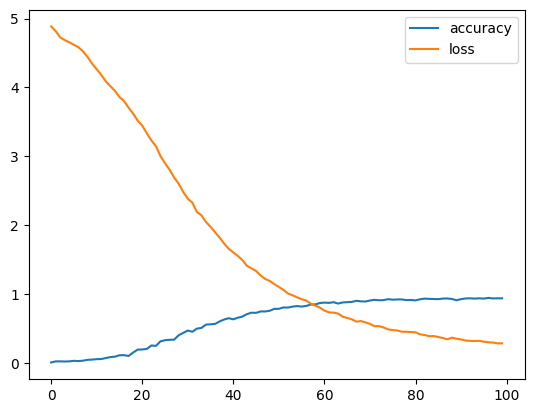

In [14]:
plt.plot(train.history['accuracy'], label='accuracy')
plt.plot(train.history['loss'], label='loss')
plt.legend()

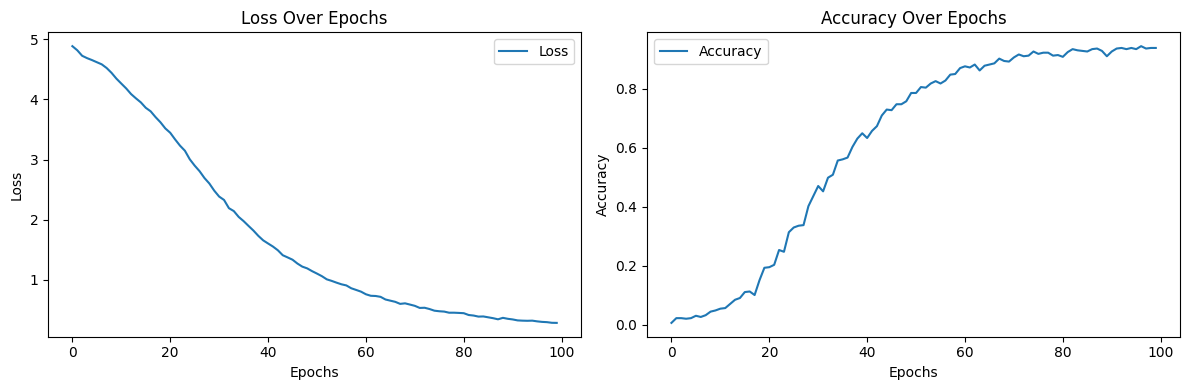

In [15]:
def plot_train_history(train):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train.history['loss'], label='Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train.history['accuracy'], label='Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_train_history(train)

## SAVE MODEL

In [16]:
model.save("chatbot_engmodel.h5")
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(label, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Load necessary files
model = tf.keras.models.load_model('chatbot_engmodel.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('label_encoder.pickle', 'rb') as enc_file:
    lbl_encoder = pickle.load(enc_file)
with open('engdataset.json', 'r') as data_file:
    data1 = json.load(data_file)

## TESTING MODEL

In [18]:
pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=187487 sha256=c39bbe7d034fc432fa7e9d4057d711a75f93f97cf7270ef2e0c258b4ddae9cce
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [19]:
from symspellpy.symspellpy import SymSpell, Verbosity

# Initialize SymSpell for typo correction
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

def correct_typo(input_text):
    suggestions = sym_spell.lookup_compound(input_text, max_edit_distance=2)
    # Return the corrected input if any suggestions exist
    if suggestions:
        return suggestions[0].term
    return input_text

def chat():
    print("Start chatting with the bot (type 'quit' to stop)!")
    while True:
        print("User: ", end="")
        inp = input()
        if inp.lower() == "quit":
            break

        # Correct typos in user input
        corrected_input = correct_typo(inp)

        # Process the corrected input
        result = model.predict(pad_sequences(tokenizer.texts_to_sequences([corrected_input]), truncating='post', maxlen=input_shape))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for intent in data1['intents']:
            if intent['tag'] == tag:
                print("Chatbot: ", np.random.choice(intent['responses']))

chat()

Start chatting with the bot (type 'quit' to stop)!
User: Hello
1/1 [==============================] - 1s 658ms/step
Chatbot:  Hello there. Tell me how are you feeling today?
User: I feel down
1/1 [==============================] - 0s 19ms/step
Chatbot:  I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?
User: I am so anxious because of my project
1/1 [==============================] - 0s 18ms/step
Chatbot:  It's important to find support. Are there any parenting groups or resources you can access?
User: I need some motivation
1/1 [==============================] - 0s 20ms/step
Chatbot:  You're stronger than you think. Keep going!
User: That's helpful
1/1 [==============================] - 0s 17ms/step
Chatbot:  You're most welcome!
User: Thank you
1/1 [==============================] - 0s 18ms/step
Chatbot:  My pleasure
User: quit


## CONVERT TFLITE

In [20]:
model = tf.keras.models.load_model('chatbot_engmodel.h5')

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TFLite default ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TF ops
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

In [22]:
tflite_model_path = 'chatbot_engmodel.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to {tflite_model_path}")

TFLite model saved to chatbot_engmodel.tflite
